In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt


In [2]:
def read_logs(fpath):
    f = open(fpath, 'r')
    lines = f.readlines()
    f.close()
    
    data = list( map( lambda s: s.strip().split(), lines) )
    if len(data[-1]) != len(data[-2]):
        data.pop(-1)
    
    df = pl.DataFrame( data,
                       orient ='row',
                       schema = {'n_epochs' : pl.Int32, 'initial_lr' : pl.Float32,
                                 'decay_rate' : pl.Float32, 'regularization_alpha' : pl.Float32,
                                 'elapsed_time' : pl.Float32, 'train_loss' : pl.Float64, 'test_loss' : pl.Float64 } )

    return df


In [3]:
def make_df():
    py_df = read_logs('./LinearRegression/logs/py_log.txt')
    cpp_df = read_logs('./LinearRegression/logs/cpp_log.txt')

    df = pl.DataFrame(data = np.zeros( shape= (py_df.shape[0], py_df.shape[1]+3)),
        schema = {'n_epochs' : pl.Int32, 'initial_lr' : pl.Float32,
                                'decay_rate' : pl.Float32, 'regularization_alpha' : pl.Float32,
                                'cpp_elapsed_time' : pl.Float32, 'cpp_train_loss' : pl.Float64, 'cpp_test_loss' : pl.Float64,
                                'py_elapsed_time' : pl.Float32, 'py_train_loss' : pl.Float64, 'py_test_loss' : pl.Float64} )

    
    df = df.with_columns(
     [pl.lit(cpp_df[c]).alias(c) for c in py_df.columns[:4]] + 
     [pl.lit(cpp_df[c]).alias('cpp_' + c) for c in cpp_df.columns[4:]] +
     [pl.lit(py_df[c]).alias('py_' + c) for c in py_df.columns[4:]]
    )
    
    return df
    

In [4]:
#custom format
def c_f(d,k):
    if k == 'n_epochs':
        return str(d[k][0])
    elif k == 'decay_rate':
        return f"{d[k][0]:.1f}"
    elif k == 'initial_lr':
        return f"{d[k][0]:.2e}"
    elif k == 'regularization_alpha':
        return f"{d[k][0]:.2e}"
        

In [5]:
# hp must be in ["decay_rate", "initial_lr", "regularization_alpha", "n_epochs"]
def plot_lossVShp(df, hp, ix):

    hps = ["decay_rate", "initial_lr", "regularization_alpha", "n_epochs"]
    
    df = df.group_by(
    [x for x in hps if x != hp]).agg(
        pl.col(hp), pl.col("cpp_train_loss"), pl.col("py_train_loss"), pl.col("cpp_test_loss"), pl.col("py_test_loss") )

    if ix is None:
        ix = np.random.randint(0,df.shape[0])
    
    data = df[ix,]
    d = data[ : , :3 ].to_dict()
    
    title = f"ix: {ix} | " + " | ".join([ f"{k} : {c_f(d,k)}" for k in d.keys()])
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.subplots(1,1)
    ax.set_xlabel(hp)
    ax.set_ylabel('loss')
    ax.set_title( title )
    
    ax.plot(data[hp][0], data['cpp_train_loss'][0],
            c='blue', marker='*', mfc='red', mec='red', label='cpp_train')

    ax.plot(data[hp][0], data['cpp_test_loss'][0],
          c='red', marker='*', mfc='blue', mec='blue', label='cpp_test')

    ax.plot(data[hp][0], data['py_train_loss'][0],
            c='green', marker='*', mfc='orange', mec='orange', label='py_train')
    
    ax.plot(data[hp][0], data['py_test_loss'][0],
            c='orange', marker='*', mfc='green', mec='green', label='py_test')

    ax.legend()
    

In [6]:
def plot_timeVSepochs(df, ix):
    
    hps = ["decay_rate", "initial_lr", "regularization_alpha"]
    
    df = df.group_by(hps).agg(pl.col("n_epochs"), pl.col("cpp_elapsed_time"), pl.col("py_elapsed_time") )

    if ix is None:
        ix = np.random.randint(0,df.shape[0])
    
    data = df[ix,]
    d = data[ : , :3 ].to_dict()
    
    title = f"ix: {ix} | " + " | ".join([ f"{k} : {c_f(d,k)}" for k in d.keys()])
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.subplots(1,1)
    ax.set_xlabel("n_epochs")
    ax.set_ylabel('elapsed_time (seconds)')
    ax.set_title( title )
    
    ax.plot(data["n_epochs"][0], data['cpp_elapsed_time'][0],
            c='blue', marker='*', mfc='red', mec='red', label='cpp')
    
    ax.plot(data["n_epochs"][0], data['py_elapsed_time'][0],
            c='green', marker='*', mfc='orange', mec='orange', label='py')

    ax.legend()
    

In [7]:
df = make_df()
df


n_epochs,initial_lr,decay_rate,regularization_alpha,cpp_elapsed_time,cpp_train_loss,cpp_test_loss,py_elapsed_time,py_train_loss,py_test_loss
i32,f32,f32,f32,f32,f64,f64,f32,f64,f64
128,1.0,0.1,0.01,0.122835,0.0289173,0.009746,0.164321,12.627112,24.453695
128,1.0,0.1,0.005,0.122627,0.0279756,0.009543,0.160457,1.2269e10,2.3656e10
128,1.0,0.1,0.001,0.117628,0.0270737,0.009667,0.214285,1.6489e16,3.1568e16
128,1.0,0.1,0.0005,0.140727,0.0269299,0.009754,0.198808,5.7853e16,1.1539e17
128,1.0,0.1,0.0001,0.117243,0.026819,0.0098697,0.196447,1.5294e17,1.8541e17
…,…,…,…,…,…,…,…,…,…
4096,0.0001,0.7,0.005,6.13429,0.0353424,0.0143616,8.927093,0.037597,0.045978
4096,0.0001,0.7,0.001,6.08876,0.0550649,0.022746,10.92662,0.035068,0.04338
4096,0.0001,0.7,0.0005,6.54666,0.0489543,0.0173562,9.909935,0.034704,0.04291


In [22]:
data = df.filter( (pl.col("cpp_train_loss") < 0.3) & (pl.col("py_train_loss") < 0.3) )
data


n_epochs,initial_lr,decay_rate,regularization_alpha,cpp_elapsed_time,cpp_train_loss,cpp_test_loss,py_elapsed_time,py_train_loss,py_test_loss
i32,f32,f32,f32,f32,f64,f64,f32,f64,f64
128,1.0,0.2,0.01,0.159916,0.0291574,0.009856,0.338921,0.050134,0.049752
128,1.0,0.2,0.005,0.1489,0.0284989,0.009698,0.239589,0.047693,0.046583
128,1.0,0.2,0.001,0.140787,0.0277857,0.009713,0.278999,0.045473,0.042759
128,1.0,0.2,0.0005,0.125954,0.0276559,0.009529,0.189903,0.046516,0.043459
128,1.0,0.2,0.0001,0.123205,0.0274898,0.009549,0.173472,0.072982,0.06349
…,…,…,…,…,…,…,…,…,…
4096,0.0001,0.7,0.005,6.13429,0.0353424,0.0143616,8.927093,0.037597,0.045978
4096,0.0001,0.7,0.001,6.08876,0.0550649,0.022746,10.92662,0.035068,0.04338
4096,0.0001,0.7,0.0005,6.54666,0.0489543,0.0173562,9.909935,0.034704,0.04291


In [23]:
data[ ["cpp_train_loss", "py_train_loss"] ].describe()

statistic,cpp_train_loss,py_train_loss
str,f64,f64
"""count""",1218.0,1218.0
"""null_count""",0.0,0.0
"""mean""",0.035478,0.031645
"""std""",0.006866,0.009188
"""min""",0.0261077,0.020269
"""25%""",0.0315778,0.024188
"""50%""",0.0341686,0.028016
"""75%""",0.0366067,0.038094
"""max""",0.0638028,0.072982


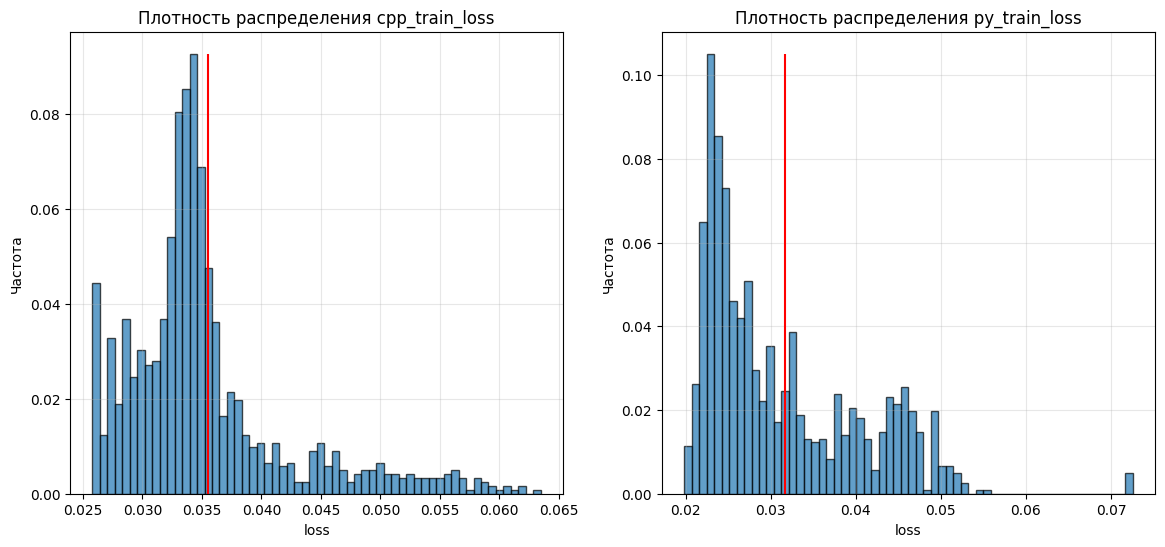

In [24]:
fig = plt.figure(figsize=(14, 6))
axes = fig.subplots(1,2)
cnt_bins = 60
for i,n in zip(range(2), ['cpp','py']):
    
    counts, bins = np.histogram(data[f"{n}_train_loss"], bins=cnt_bins)
    relative_freq = counts / len(data[f"{n}_train_loss"])  
    bin_width = bins[1] - bins[0]
    axes[i].bar(bins[:-1], relative_freq, width=bin_width, alpha=0.7, edgecolor='black')

    axes[i].set_title(f"Плотность распределения {n}_train_loss")
    axes[i].set_xlabel('loss')
    axes[i].set_ylabel('Частота')
    axes[i].grid(alpha=0.3)
    axes[i].vlines(data[f"{n}_train_loss"].mean(),ymin=0,ymax=max(relative_freq), color='red')
    

In [25]:
data[ ["cpp_test_loss", "py_test_loss"] ].describe()

statistic,cpp_test_loss,py_test_loss
str,f64,f64
"""count""",1218.0,1218.0
"""null_count""",0.0,0.0
"""mean""",0.012706,0.038417
"""std""",0.003138,0.007281
"""min""",0.009474,0.026778
"""25%""",0.0109902,0.032615
"""50%""",0.0119164,0.036774
"""75%""",0.0130503,0.042163
"""max""",0.0296832,0.071937


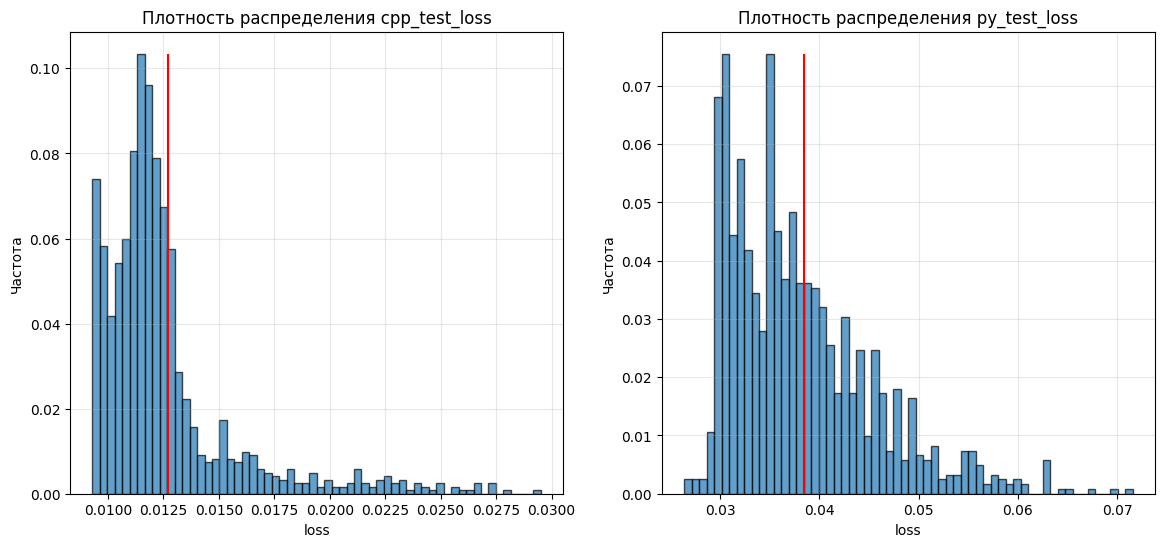

In [26]:
fig = plt.figure(figsize=(14, 6))
axes = fig.subplots(1,2)
cnt_bins = 60
for i,n in zip(range(2), ['cpp','py']):
    
    counts, bins = np.histogram(data[f"{n}_test_loss"], bins=cnt_bins)
    relative_freq = counts / len(data[f"{n}_test_loss"])  
    bin_width = bins[1] - bins[0]
    axes[i].bar(bins[:-1], relative_freq, width=bin_width, alpha=0.7, edgecolor='black')

    axes[i].set_title(f"Плотность распределения {n}_test_loss")
    axes[i].set_xlabel('loss')
    axes[i].set_ylabel('Частота')
    axes[i].grid(alpha=0.3)
    axes[i].vlines(data[f"{n}_test_loss"].mean(),ymin=0,ymax=max(relative_freq), color='red')
    

In [27]:
n_epochs = 512 # must be from [128, 256, 512, 1024, 2048, 4096]
data2 = df.filter( pl.col('n_epochs') == n_epochs )
data2

n_epochs,initial_lr,decay_rate,regularization_alpha,cpp_elapsed_time,cpp_train_loss,cpp_test_loss,py_elapsed_time,py_train_loss,py_test_loss
i32,f32,f32,f32,f32,f64,f64,f32,f64,f64
512,1.0,0.1,0.01,0.499154,0.0287156,0.009651,0.656518,13.870925,26.827817
512,1.0,0.1,0.005,0.466165,0.0274419,0.0094739,0.630468,9.6281e9,1.8564e10
512,1.0,0.1,0.001,0.564121,0.0262508,0.0107413,0.658432,2.8853e16,5.5279e16
512,1.0,0.1,0.0005,0.461631,0.0261602,0.0112331,0.642138,5.8482e16,1.1665e17
512,1.0,0.1,0.0001,0.516505,0.0261162,0.0117606,0.629354,2.0609e17,1.6108e17
…,…,…,…,…,…,…,…,…,…
512,0.0001,0.7,0.005,0.674176,0.0349851,0.0125319,0.913345,0.049584,0.058903
512,0.0001,0.7,0.001,0.484071,0.0333955,0.012503,0.929203,0.04578,0.054682
512,0.0001,0.7,0.0005,0.464338,0.0484922,0.0167691,0.694535,0.046953,0.05578


In [28]:
data2[ ["cpp_elapsed_time", "py_elapsed_time"] ].describe()

statistic,cpp_elapsed_time,py_elapsed_time
str,f64,f64
"""count""",210.0,210.0
"""null_count""",0.0,0.0
"""mean""",0.499985,0.761898
"""std""",0.048573,0.128877
"""min""",0.456012,0.612313
"""25%""",0.4661,0.656518
"""50%""",0.479651,0.709481
"""75%""",0.520137,0.864836
"""max""",0.723082,1.127405


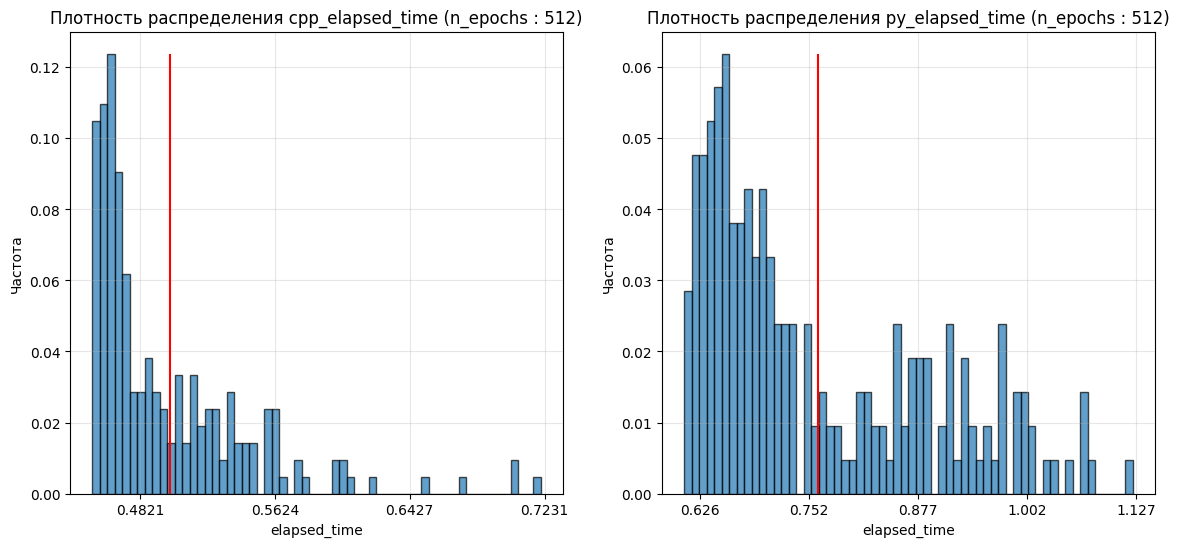

In [29]:
fig = plt.figure(figsize=(14, 6))
axes = fig.subplots(1,2)
cnt_bins = 60
for i,n in zip(range(2), ['cpp','py']):
    
    counts, bins = np.histogram(data2[f"{n}_elapsed_time"], bins=cnt_bins)
    relative_freq = counts / len(data2[f"{n}_elapsed_time"])  
    bin_width = bins[1] - bins[0]
    axes[i].bar(bins[:-1], relative_freq, width=bin_width, alpha=0.7, edgecolor='black')

    axes[i].set_title(f"Плотность распределения {n}_elapsed_time (n_epochs : {n_epochs})")
    axes[i].set_xlabel('elapsed_time')
    axes[i].set_ylabel('Частота')
    axes[i].grid(alpha=0.3)
    axes[i].set_xticks( np.linspace(0, bins[-1], 10) )
    axes[i].vlines(data2[f"{n}_elapsed_time"].mean(),ymin=0, ymax=max(relative_freq), color='red')
    

In [30]:
n_samples = 3

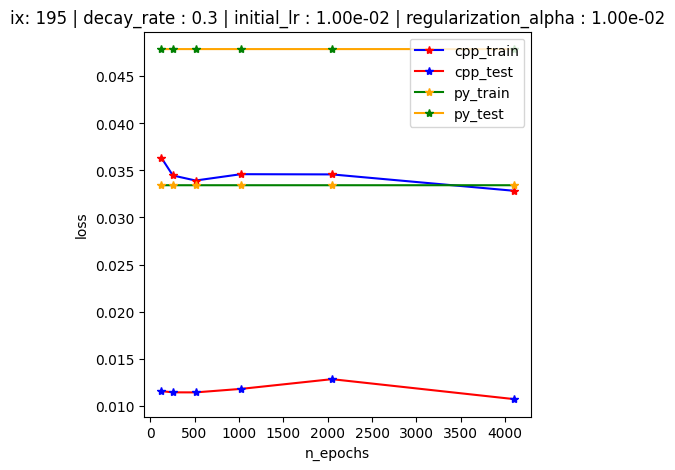

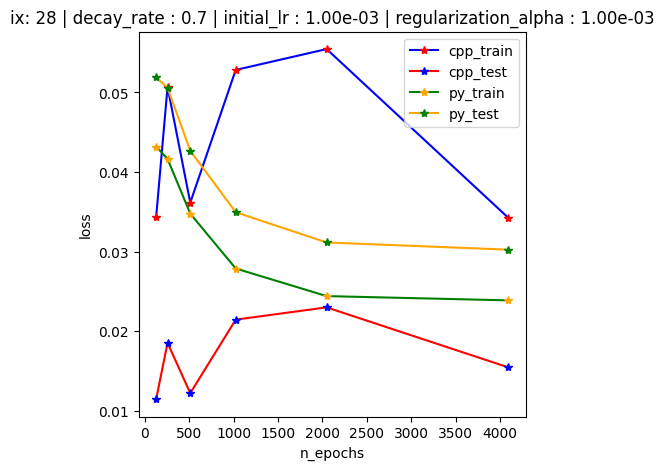

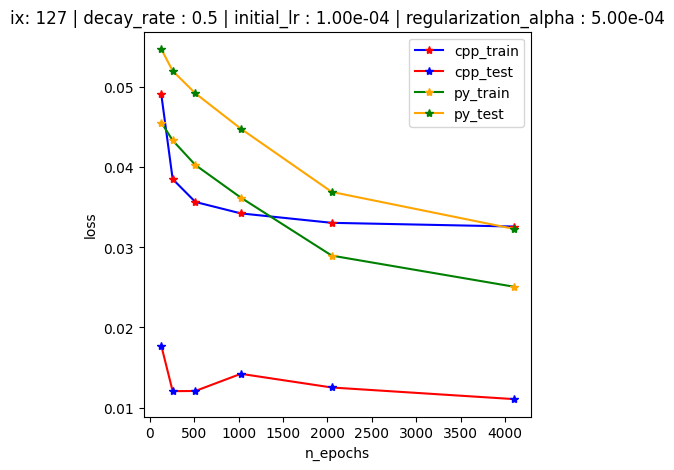

In [31]:
for i in range(n_samples):
    plot_lossVShp(df, "n_epochs", None)

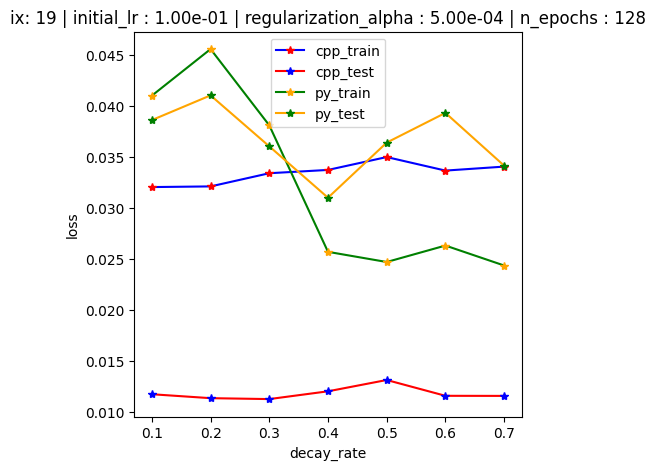

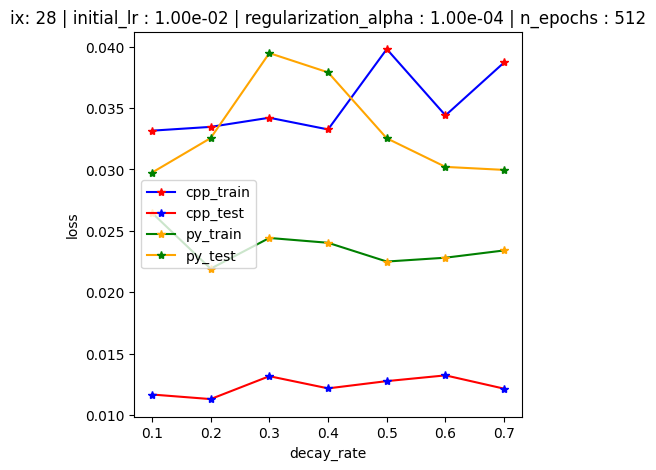

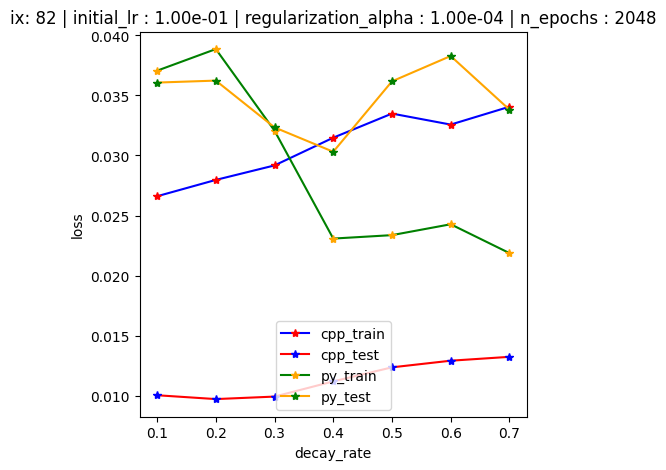

In [32]:
for i in range(n_samples):
    plot_lossVShp(df, "decay_rate", None)

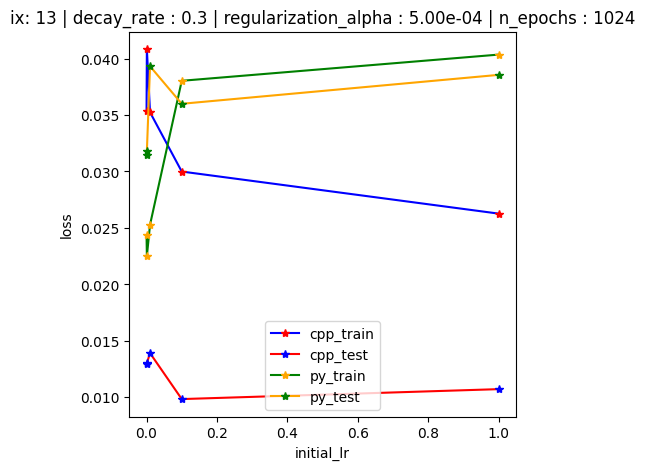

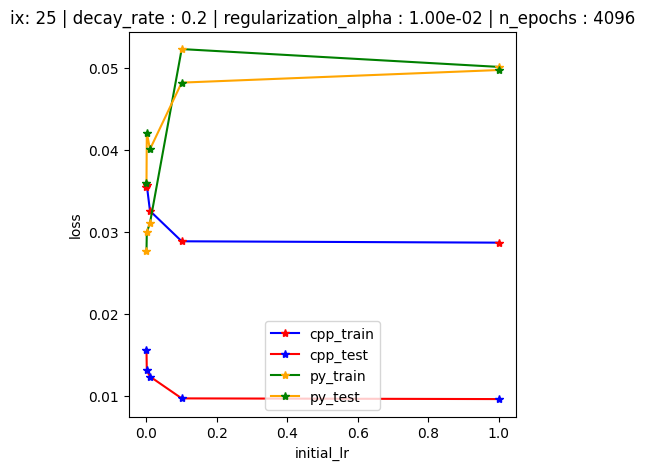

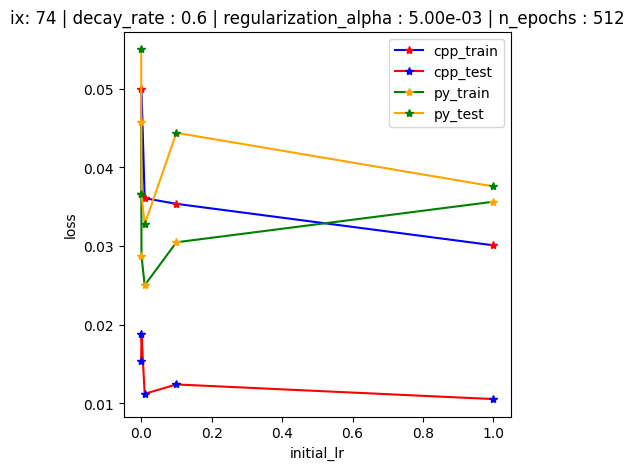

In [33]:
for i in range(n_samples):
    plot_lossVShp(df, "initial_lr", None)

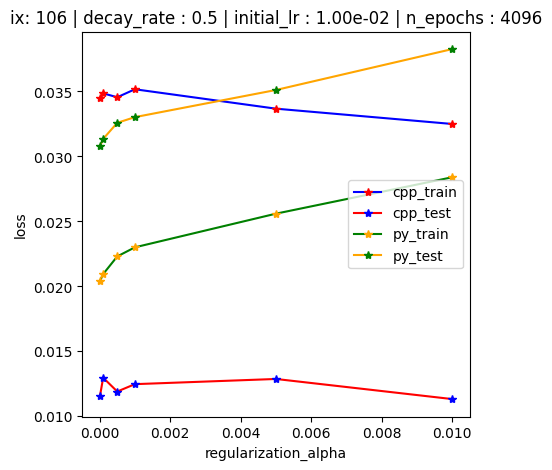

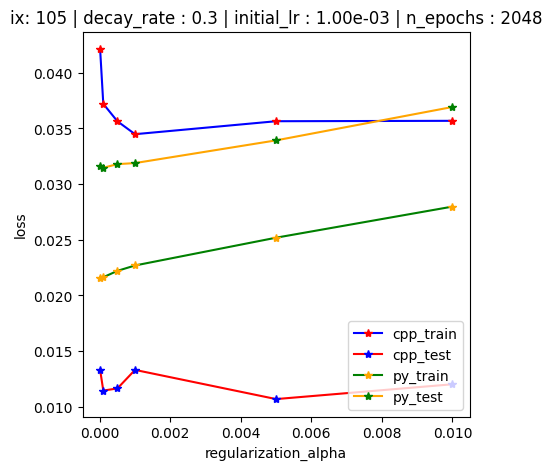

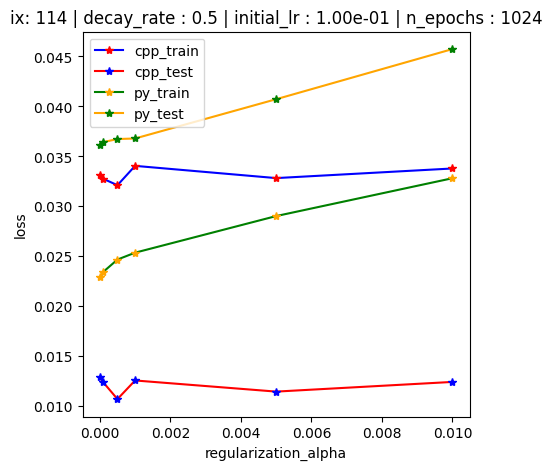

In [34]:
for i in range(n_samples):
    plot_lossVShp(df, "regularization_alpha", None)

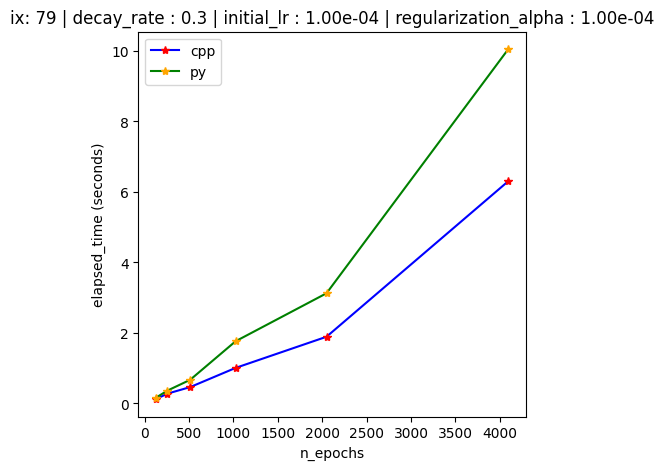

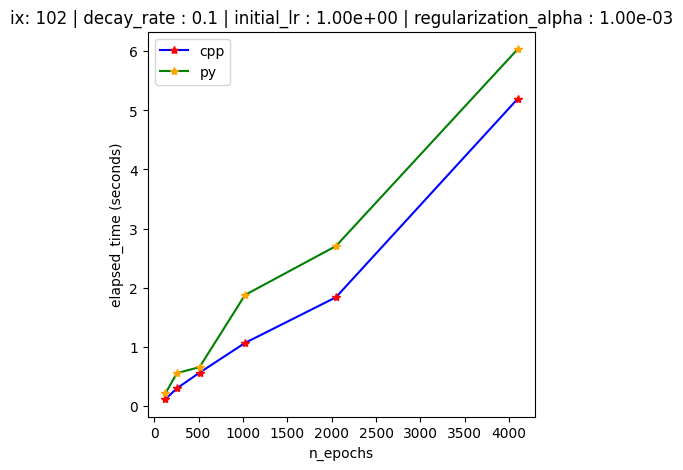

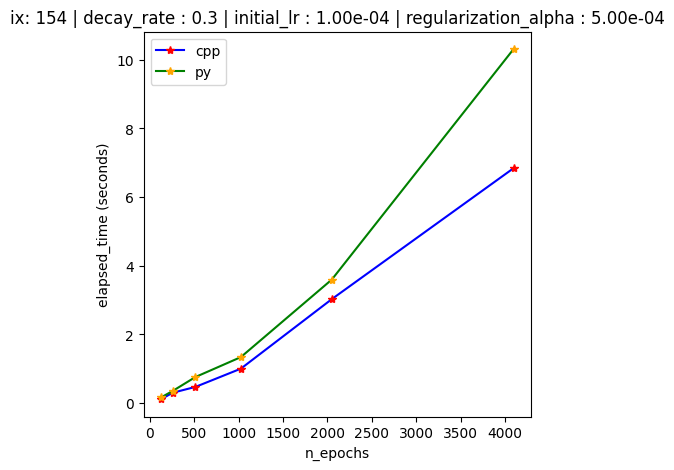

In [35]:
for i in range(n_samples):
    plot_timeVSepochs(df,None)